Objective 1: KMeans Clustering on Supplier Behavior (usupervised)
Goal:
-Group suppliers based on their financial impact—how much they owe, pay, how often they're in disputes, and payment delays.

Data to Use:
From fact_financialSituation + dim_supplier + dim_disputes
AmountDue, AmountPaid, BalanceDue
Dispute frequency (count of disputes per supplier)
Average payment delay (PaymentDate - DueDate)

Cluster suppliers into groups like:
Reliable & timely
Frequently late
Dispute-prone
Expensive but efficient, etc.

Algorithm:
K-Means: We used K-Means clustering to divide the data into groups, where similar suppliers are grouped together based on the features: payment delays, amounts due, etc..
Output: The result of clustering is to categorize the data into distinct groups (clusters), which helps identify patterns, anomalies, or groups that require attention.

In [2]:
import pyodbc
import pandas as pd

# Set your credentials here
server = 'DESKTOP-MFO02KK'  
database = 'DW_Finance'  
username = 'nesrine'  
password = 'nesrine'

# Use SQL Server Authentication
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

conn = pyodbc.connect(conn_str)




In [ ]:
query = "SELECT TOP 5 * FROM Fact_Financial_Situation"
df = pd.read_sql(query, conn)

print(df.head())


C:\Users\bouss\AppData\Local\Temp\ipykernel_15880\3956821807.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


  Fk_Account  Fk_Grand_Livre  Fk_Disputes  Fk_Supplier  Fk_Invoices  Fk_Date  \
0       None            1133         6999            2         9114     3854   
1       None            1074         6979            8         9087     4324   
2       None            3430         6986           10         8729     5487   
3       None            4896         6997            1         9096     4890   
4       None             525         6989            4         8898     3848   

   Fk_Geographie Fk_EntryDate  Fk_TransactionDate  Fk_DisputeDate  ...  \
0              2         None                3854            4924  ...   
1              4         None                4324            4415  ...   
2              3         None                5487            4301  ...   
3              1         None                4890            3867  ...   
4              4         None                3848            5051  ...   

   Fk_PaymentDate  Fk_InvoiceDate  TotalAssets  TotalLiabilities    Equity

#Objective1: Clustering using Kmeans

C:\Users\bouss\AppData\Local\Temp\ipykernel_12996\4187776763.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


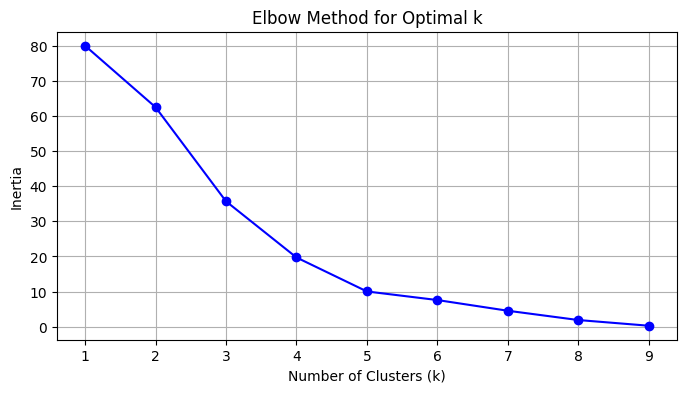

✅ Silhouette Score: 0.39


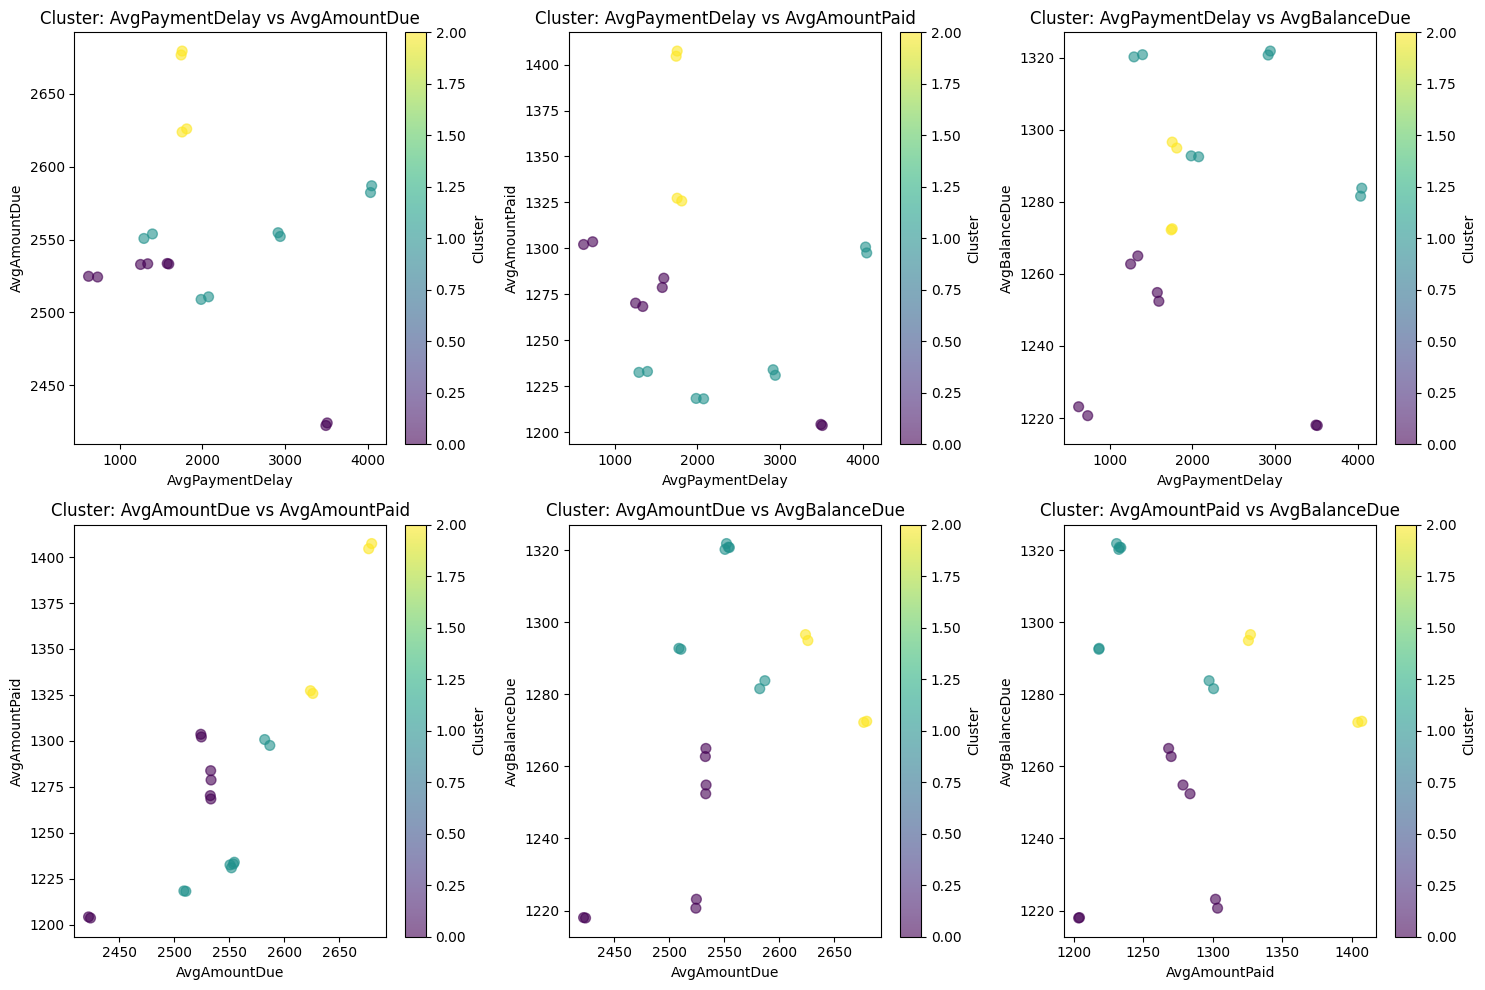

🔮 Predicted cluster for new supplier data: 2


C:\Users\bouss\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [4]:
#update after data augmentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Preprocess and clean the data
query = """
SELECT 
    s.SupplierID,
    s.Name,
    COUNT(d.DisputeID) AS DisputeCount,
    AVG(DATEDIFF(DAY, fs.Fk_DueDate, fs.Fk_PaymentDate)) AS AvgPaymentDelay,
    AVG(fs.AmountDue) AS AvgAmountDue,
    AVG(fs.AmountPaid) AS AvgAmountPaid,
    AVG(fs.BalanceDue) AS AvgBalanceDue
FROM dbo.Fact_Financial_Situation fs
JOIN dbo.dim_supplier s ON fs.Fk_Supplier = s.Pk_Supplier
LEFT JOIN dbo.dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
GROUP BY s.SupplierID, s.Name
"""

df = pd.read_sql(query, conn)

# Step 1.5: ✅ Data Augmentation (adding noise to numeric features)
augmented_df = df.copy()
noise_factor = 0.05  # 5% noise

for col in ['AvgPaymentDelay', 'AvgAmountDue', 'AvgAmountPaid', 'AvgBalanceDue']:
    noise = np.random.normal(0, noise_factor * df[col].std(), size=len(df))
    augmented_df[col] = df[col] + noise

# Combine original and augmented data
df_combined = pd.concat([df, augmented_df], ignore_index=True)

# Step 2: Feature selection and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

features = df_combined[['AvgPaymentDelay', 'AvgAmountDue', 'AvgAmountPaid', 'AvgBalanceDue']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 3: Elbow Method to choose optimal k
inertia = []
K_range = range(1, min(len(X_scaled), 10))  # Avoid k > number of samples

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Step 4: Train final model with chosen k (e.g., 3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_combined['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 5: Evaluate clustering quality
silhouette = silhouette_score(X_scaled, df_combined['Cluster'])
print(f"✅ Silhouette Score: {silhouette:.2f}")

# Step 6: Plot clusters for feature pairs
feature_pairs = [
    ('AvgPaymentDelay', 'AvgAmountDue'),
    ('AvgPaymentDelay', 'AvgAmountPaid'),
    ('AvgPaymentDelay', 'AvgBalanceDue'),
    ('AvgAmountDue', 'AvgAmountPaid'),
    ('AvgAmountDue', 'AvgBalanceDue'),
    ('AvgAmountPaid', 'AvgBalanceDue')
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (fx, fy) in enumerate(feature_pairs):
    ax = axes[i]
    scatter = ax.scatter(df_combined[fx], df_combined[fy], c=df_combined['Cluster'], cmap='viridis', s=50, alpha=0.6)
    ax.set_title(f'Cluster: {fx} vs {fy}')
    ax.set_xlabel(fx)
    ax.set_ylabel(fy)
    fig.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.show()

# Step 7: Test new supplier data for cluster prediction
# Example new data: [AvgPaymentDelay, AvgAmountDue, AvgAmountPaid, AvgBalanceDue]
new_data = [[12.0, 5000.0, 4800.0, 200.0]]
new_data_scaled = scaler.transform(new_data)
predicted_cluster = kmeans.predict(new_data_scaled)
print("🔮 Predicted cluster for new supplier data:", predicted_cluster[0])


C:\Users\bouss\AppData\Local\Temp\ipykernel_13048\3626627202.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


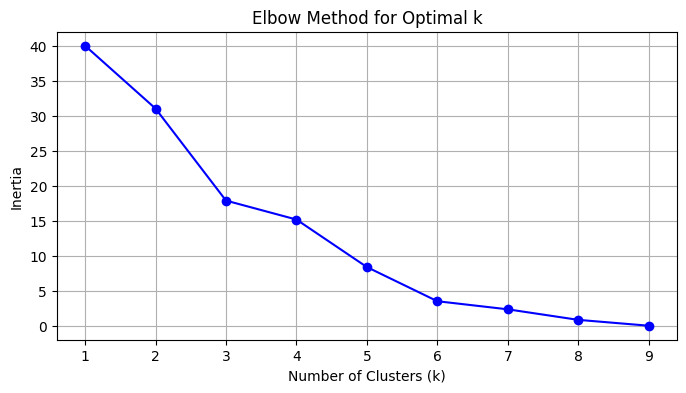

✅ Silhouette Score: 0.27


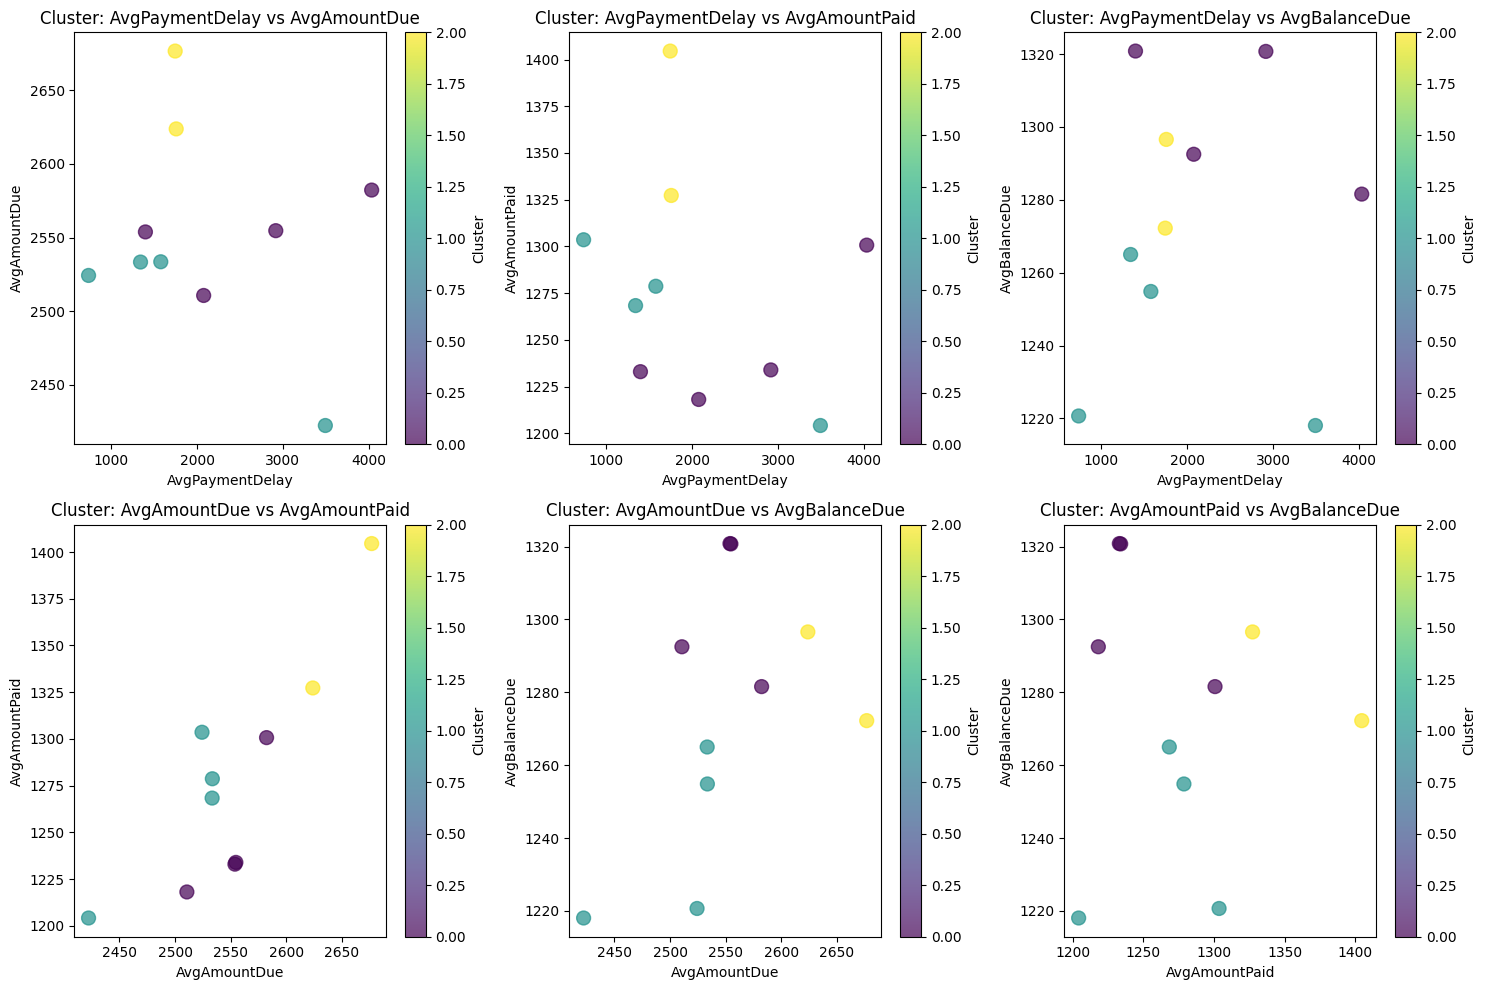

🔮 Predicted cluster for new supplier data: 2


C:\Users\bouss\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [11]:
# Step 1: Preprocess and clean the data
query = """
SELECT 
    s.SupplierID,
    s.Name,
    COUNT(d.DisputeID) AS DisputeCount,
    AVG(DATEDIFF(DAY, fs.Fk_DueDate, fs.Fk_PaymentDate)) AS AvgPaymentDelay,
    AVG(fs.AmountDue) AS AvgAmountDue,
    AVG(fs.AmountPaid) AS AvgAmountPaid,
    AVG(fs.BalanceDue) AS AvgBalanceDue
FROM dbo.Fact_Financial_Situation fs
JOIN dbo.dim_supplier s ON fs.Fk_Supplier = s.Pk_Supplier
LEFT JOIN dbo.dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
GROUP BY s.SupplierID, s.Name
"""

df = pd.read_sql(query, conn)

# Step 2: Feature selection and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

features = df[['AvgPaymentDelay', 'AvgAmountDue', 'AvgAmountPaid', 'AvgBalanceDue']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 3: Elbow Method to choose optimal k
inertia = []
K_range = range(1, min(len(X_scaled), 10))  # Avoid k > number of samples

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Step 4: Train final model with chosen k (e.g., 3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 5: Evaluate clustering quality
silhouette = silhouette_score(X_scaled, df['Cluster'])
print(f"✅ Silhouette Score: {silhouette:.2f}")

# Step 6: Plot clusters for feature pairs
feature_pairs = [
    ('AvgPaymentDelay', 'AvgAmountDue'),
    ('AvgPaymentDelay', 'AvgAmountPaid'),
    ('AvgPaymentDelay', 'AvgBalanceDue'),
    ('AvgAmountDue', 'AvgAmountPaid'),
    ('AvgAmountDue', 'AvgBalanceDue'),
    ('AvgAmountPaid', 'AvgBalanceDue')
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (fx, fy) in enumerate(feature_pairs):
    ax = axes[i]
    scatter = ax.scatter(df[fx], df[fy], c=df['Cluster'], cmap='viridis', s=100, alpha=0.7)
    ax.set_title(f'Cluster: {fx} vs {fy}')
    ax.set_xlabel(fx)
    ax.set_ylabel(fy)
    fig.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.show()

# Step 7: Test new supplier data for cluster prediction
# Example new data: [AvgPaymentDelay, AvgAmountDue, AvgAmountPaid, AvgBalanceDue]
new_data = [[12.0, 5000.0, 4800.0, 200.0]]
new_data_scaled = scaler.transform(new_data)
predicted_cluster = kmeans.predict(new_data_scaled)
print("🔮 Predicted cluster for new supplier data:", predicted_cluster[0])


C:\Users\bouss\AppData\Local\Temp\ipykernel_15880\1404765522.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


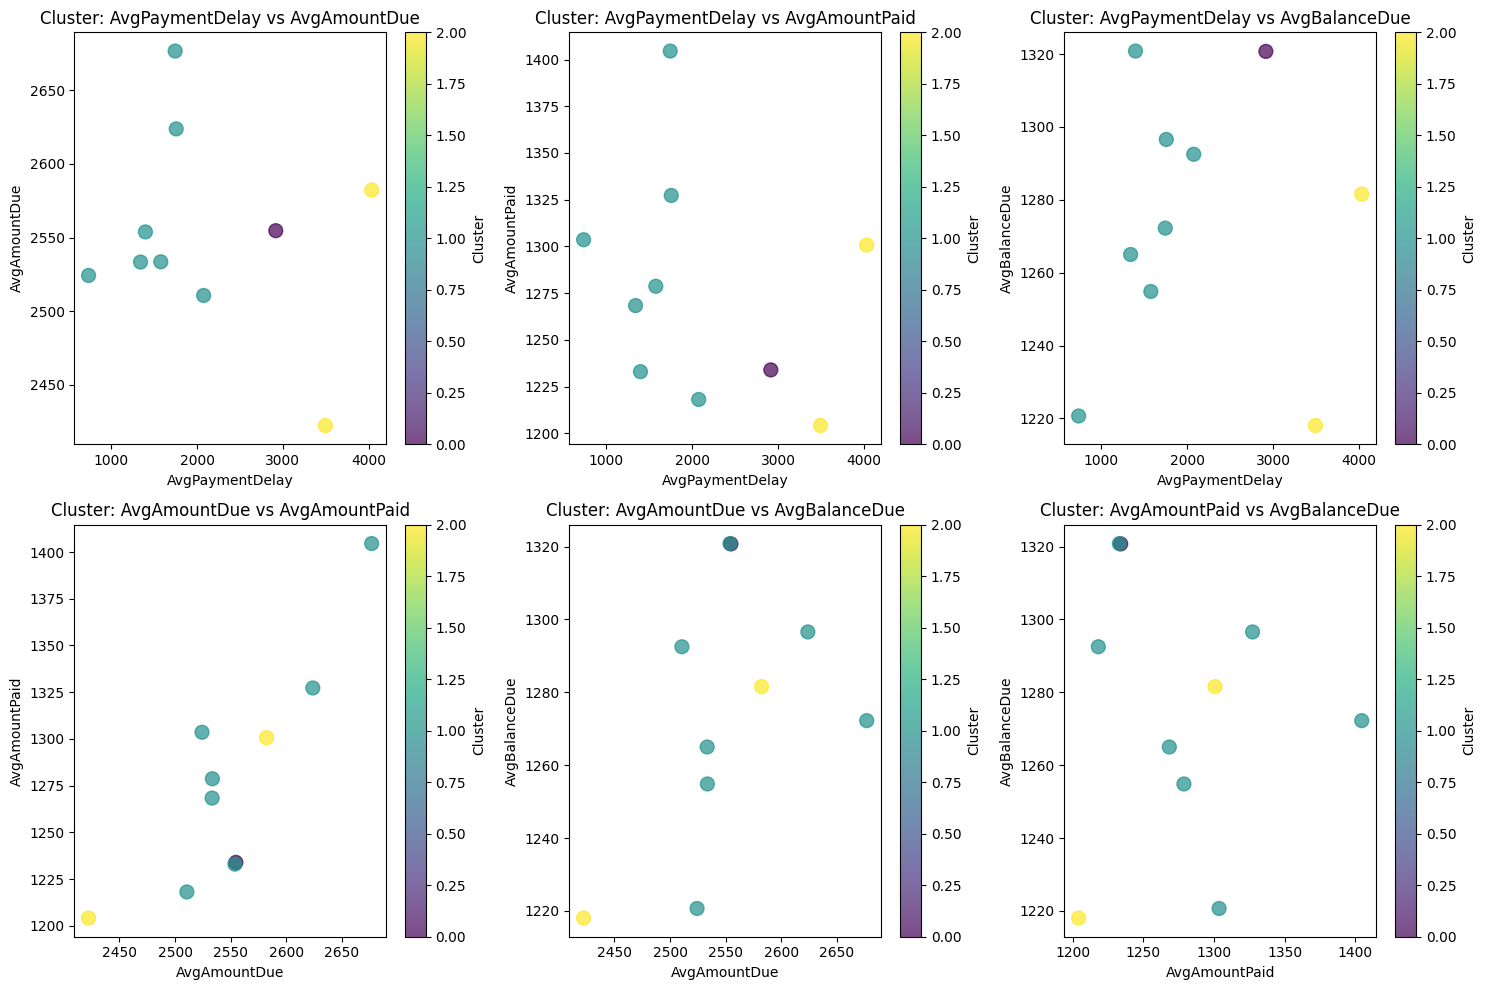

In [ ]:
# Step 1: Preprocess and clean the data (same as before)
query = """
SELECT 
    s.SupplierID,
    s.Name,
    COUNT(d.DisputeID) AS DisputeCount,
    AVG(DATEDIFF(DAY, fs.Fk_DueDate, fs.Fk_PaymentDate)) AS AvgPaymentDelay,
    AVG(fs.AmountDue) AS AvgAmountDue,
    AVG(fs.AmountPaid) AS AvgAmountPaid,
    AVG(fs.BalanceDue) AS AvgBalanceDue
FROM dbo.Fact_Financial_Situation fs
JOIN dbo.dim_supplier s ON fs.Fk_Supplier = s.Pk_Supplier
LEFT JOIN dbo.dim_disputes d ON fs.Fk_Disputes = d.Pk_Disputes
GROUP BY s.SupplierID, s.Name
"""

df = pd.read_sql(query, conn)

# Step 2: Apply KMeans clustering (same as before)
from sklearn.cluster import KMeans

# Selecting the numerical columns for clustering
features = df[['AvgPaymentDelay', 'AvgAmountDue', 'AvgAmountPaid', 'AvgBalanceDue']]

# Perform KMeans clustering with 3 clusters (you can adjust the number of clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

# Step 3: Plot the clusters in pairs of two features at a time
import matplotlib.pyplot as plt

# Define the feature pairs to plot
feature_pairs = [
    ('AvgPaymentDelay', 'AvgAmountDue'),
    ('AvgPaymentDelay', 'AvgAmountPaid'),
    ('AvgPaymentDelay', 'AvgBalanceDue'),
    ('AvgAmountDue', 'AvgAmountPaid'),
    ('AvgAmountDue', 'AvgBalanceDue'),
    ('AvgAmountPaid', 'AvgBalanceDue')
]

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    ax = axes[i]
    scatter = ax.scatter(df[feature_x], df[feature_y], c=df['Cluster'], cmap='viridis', s=100, alpha=0.7)
    ax.set_title(f'Cluster: {feature_x} vs {feature_y}')
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    
    # Add colorbar to each plot
    fig.colorbar(scatter, ax=ax, label='Cluster')

# Adjust layout for better readability
plt.tight_layout()
plt.show()


#Each scatter plot compares two features (e.g., AvgPaymentDelay vs AvgAmountDue, AvgAmountPaid vs AvgBalanceDue, etc.). These features represent different financial metrics, so the relationship between them will give insights into how suppliers or transactions behave in terms of payment delays, amounts due, and balances.

AvgPaymentDelay: This measures the average delay between the due date and payment date. A high value indicates that payments are frequently delayed.

AvgAmountDue: This represents the average amount owed by the supplier or the amount that was due for payment.

AvgAmountPaid: This shows the average amount paid by Monoprix for a given supplier.

AvgBalanceDue: This represents the remaining balance due after payments have been made.

2. Look at the Clusters:
The clusters (indicated by different colors) group suppliers based on their financial behavior. Here's how to interpret them:

Cluster 1, Cluster 2, Cluster 3: Each color represents a different group of suppliers that exhibit similar behaviors with respect to the selected features.

Tight vs. Spread-Out Clusters: If a cluster is tightly packed, it indicates that the suppliers in that cluster have very similar financial metrics (e.g., similar payment delays or amounts due). If a cluster is spread out, it suggests a greater variety of payment behaviors among those suppliers.

3. Interpret Relationships:
For AvgPaymentDelay vs AvgAmountDue: You might observe that suppliers who tend to have higher payment delays may also owe larger amounts (longer delays = larger debts). Conversely, suppliers who pay on time might show smaller amounts due.

For AvgAmountPaid vs AvgBalanceDue: This plot can reveal suppliers that tend to pay off their balances fully vs. those who still leave significant amounts unpaid.

4. Look for Outliers:
Outliers: These are the points that do not belong to any cluster and may be far from the general cluster groups. Outliers could represent unusual suppliers with very different behaviors (e.g., either consistently late or early in payments, or those with very high or low amounts due).

5. Cluster Characteristics:
Once you identify the clusters, you can summarize their characteristics:

Cluster 1: This could be a group of suppliers who tend to have high payment delays, large amounts due, and also large balances left unpaid. These suppliers might require more attention and action, as they have the worst financial performance.

Cluster 2: This could represent suppliers who pay on time or close to it but owe moderate amounts. These suppliers may not need immediate intervention, but monitoring is still useful.

Cluster 3: This group might include suppliers who tend to make payments promptly and clear their balances faster. These suppliers are performing well financially.

6. Strategic Insights:
Late-Paying Suppliers: Suppliers in clusters with high AvgPaymentDelay could be flagged for follow-up to reduce delays.

Large Amount Due: Suppliers in clusters with high AvgAmountDue could be prime candidates for negotiation or payment terms reassessment.

Payments vs Balances: A comparison between AvgAmountPaid and AvgBalanceDue could help identify suppliers who are frequently falling behind in clearing their dues.

In Conclusion:
The goal is to identify distinct groups of suppliers with specific financial behaviors (e.g., timely payers, late payers, or those who consistently owe large amounts). This information can help Monoprix target specific suppliers for negotiation, payment terms adjustments, or closer monitoring to improve their financial situation.